In [164]:
# 사용할 모듈 불러오기 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re


In [165]:
# 데이터 불러오기
items = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
train = pd.read_csv("./data/sales_train.csv")
test = pd.read_csv("./data/test.csv")
item_categories = pd.read_csv('./data/item_categories.csv')

In [166]:
#  date의 자료형을 object  -> dattime 으로 바꾸고 싶다. 
# 변환하는 과정  ->
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")
train["date"]. head(3) 

0   2013-01-02
1   2013-01-03
2   2013-01-05
Name: date, dtype: datetime64[ns]

# EDA

## Train
###  columns 뜻
 - data  = 날짜
 - date_block_num  = 한달 단위로 구분하기 편하게 하기 위한 데이터
 - shop_id = 가게 id
 - item_price = 아이템 가격
 - item_cnt_day = 당일 해당 아이템이 팔린 개수

In [167]:
train.info() # null 값이 모든데이터에 존재 하지 않는다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [168]:
train.describe(include = 'all')

/var/folders/pq/_bzx9rqx2hs53brb_m6pwqtc0000gn/T/ipykernel_39730/2740853986.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train.describe(include = 'all')


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
unique,1034,NaN,NaN,NaN,NaN,NaN
top,2013-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN
freq,9434,NaN,NaN,NaN,NaN,NaN
first,2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2015-10-31 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,NaN,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,NaN,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00


2013-01-01 00:00:00 ~ 2015-10-31 00:00:00  까지의 1034일간의 데이터임을 알수있다.  
item_price은 평균과 중위값의 차이가 심한 것으로 보아 이상치가 존재함을 알 수 있디.  
item_cnt_day 는일,이,삼 분위수가 1인데 비해 평균은 대략 1.2  최대값은 2168로 이상치가 존재한다.   
item_cnt_day, item_price에 최소값들은 음수이다.  

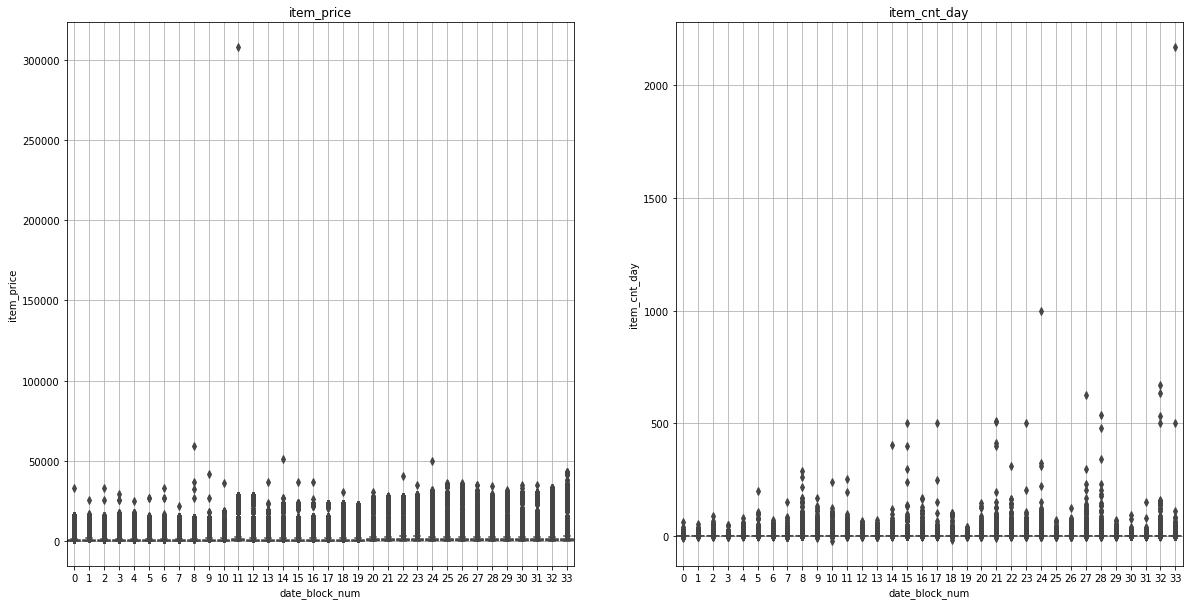

In [169]:
def price_item_cnt_day_boxplot():
    plt.figure(figsize = (20,10))
    # item_price 의 박스플롯
    plt.subplot(1,2,1)
    sns.boxplot(x = 'date_block_num' , y= 'item_price',data =train)
    plt.title('item_price')
    plt.grid()
    # item_cnt_day의 박스 플롯
    plt.subplot(1,2,2)
    sns.boxplot(x = 'date_block_num' , y= 'item_cnt_day',data =train)
    plt.title('item_cnt_day')
    plt.grid()
price_item_cnt_day_boxplot()

- 다음은 date_block_num 별로 item_price의 boxplot이다.  
- 위의 그래프를 기준으로 item_price는 50000 이상 , item_cnt_day 는 1000 이상을 이상치로서 train에서 제거한다.  
- 또한 판매되는 수량을 구하는 것이 목적이므로 0미만의 값을 제거한다.

In [170]:
condition_for_drop = ((train["item_price"] >= 50000) | (train["item_price"] < 0))
train.drop(train[condition_for_drop].index, axis = 0 , inplace=True)

condition_for_drop = ((train["item_cnt_day"] >= 1000) | (train["item_cnt_day"] < 0))
train.drop(train[condition_for_drop].index, axis = 0 , inplace=True)

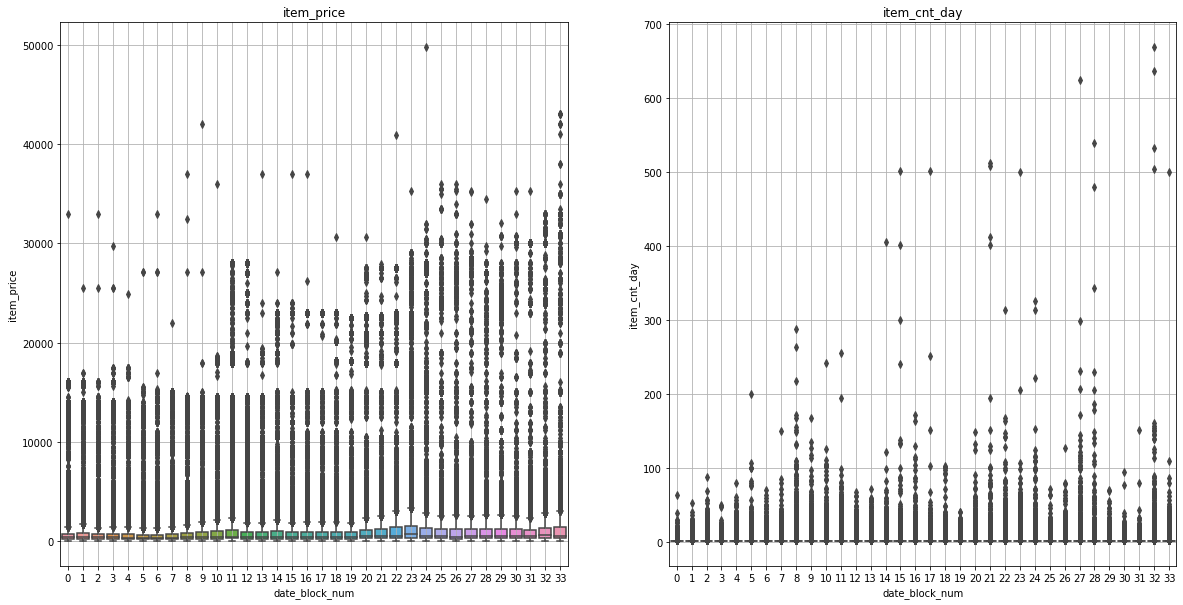

In [171]:
# 제거 후의 boxplot
price_item_cnt_day_boxplot()

In [172]:
train.corr()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.000000,0.019329,0.009472,0.095539,0.010339
shop_id,0.019329,1.000000,0.029345,-0.023955,-0.005660
item_id,0.009472,0.029345,1.000000,-0.134812,0.018896
item_price,0.095539,-0.023955,-0.134812,1.000000,0.014444
item_cnt_day,0.010339,-0.005660,0.018896,0.014444,1.000000


## shops

In [173]:
shops.info() # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [174]:
shops.head(20)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


- 이름에 특수문자가 들어가고 중복되는 이름들이 보인다

In [175]:
def clean_text(inputString):
    text_rmv = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', inputString)
    return text_rmv
shops_names = shops["shop_name"].apply(clean_text)
shops_id = shops["shop_id"]
# 중복되는 이름 확인 
for i in list(zip(shops_names ,shops_id)):
    for j in list(zip(shops_names ,shops_id)):
        if (re.match('.*'+i[0]+'*.',j[0])) and (i[1]!= j[1]):
            print('code : ', i[1], ' and  ', j[1])
            print('name : ', i[0], ' and  ', j[0])
            

code :  10  and   11
name :  Жуковский ул  Чкалова 39м   and   Жуковский ул  Чкалова 39м²
code :  11  and   10
name :  Жуковский ул  Чкалова 39м²  and   Жуковский ул  Чкалова 39м 
code :  39  and   40
name :  РостовНаДону ТРК  Мегацентр Горизонт   and   РостовНаДону ТРК  Мегацентр Горизонт  Островной
code :  57  and   0
name :  Якутск Орджоникидзе  56  and    Якутск Орджоникидзе  56 фран
code :  58  and   1
name :  Якутск ТЦ  Центральный   and    Якутск ТЦ  Центральный  фран


- 위와 같이 shop id가 10:11, 39:40, 57:0, 58:1 4개의 아이디가 중복되는 것을 알 수 있다.
- 위의 데이터를 기준으로 train data의 shop id를 바꾸어준다

In [176]:
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})

## items

In [177]:
items.info() # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [178]:
items.head(20) # 이름에 특수 문자 제거 후 비슷한 게임끼리 

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


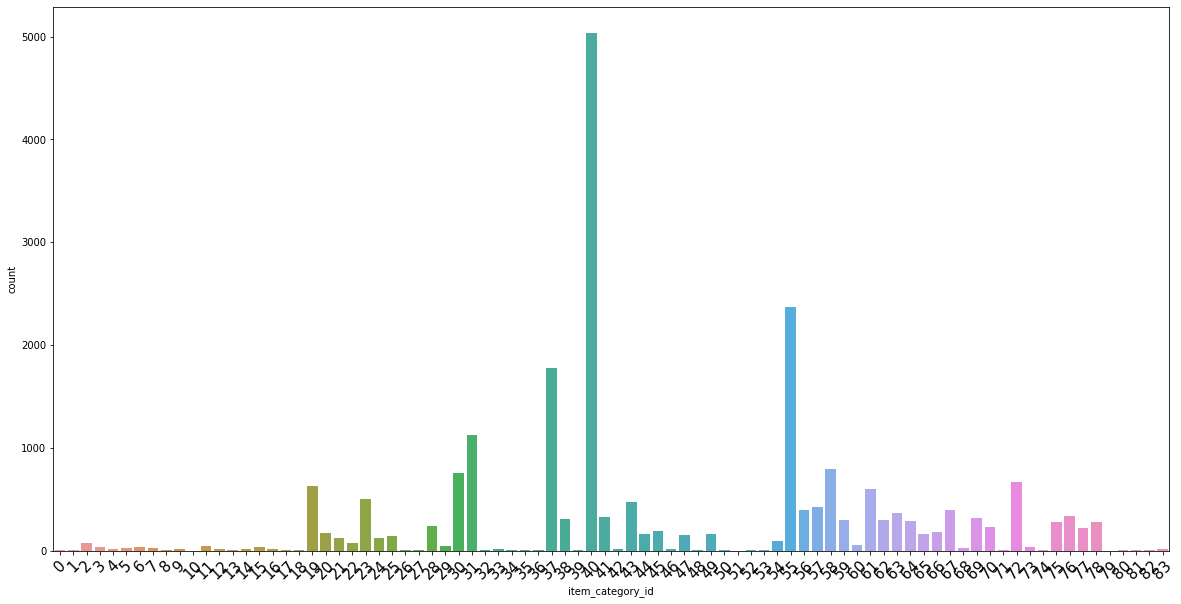

In [179]:
plt.figure(figsize=(20,10))
sns.countplot(x= 'item_category_id' , data = items)
plt.xticks(size = 15 , rotation =  45 , color = 'black')
plt.show()

In [180]:
item_categories[item_categories['item_category_id']==40]

,item_category_name,item_category_id
40,Кино - DVD,40


- item_category_id =40 인  Кино - DVD 카테고리에 많은 아이템이 존재하는지 알 수 있다

## item_category

In [181]:
item_categories.info()  # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [182]:
item_categories.head(20)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


- item_category_name에 같은 단어가 들어가는 데이터가 많이 존재한다
- 이를 묶어 더 큰 범주를 만들 수 있다.

## test

In [183]:
test.info()  # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [184]:
# test의 shop_id , item_id 기 train 데이터에 있는지 확인
diff_test_train_shop_id  = set(test['shop_id']) - set(train['shop_id'])
print('diffrent shop_id nums: ',len(diff_test_train_shop_id))
diff_test_train_item_id = set(test['item_id']) - set(train['item_id'])
print('diffrent item_id nums: ',len(diff_test_train_item_id))
diff_test_items_item_id = set(test['item_id']) - set(items['item_id'])
print('diff_test_items_itemid nums: ',len(diff_test_items_item_id))

diffrent shop_id nums:  0
diffrent item_id nums:  363
diff_test_items_itemid nums:  0


#### test에는 존재하지만 train에 존재하지 않는 값이 363개 존재한다. 
#### items에는 test에 있는 모든 item_id를 가지고 있다. 
#### 이를 해결하기위해 다음과 같은 방법을 사용한다
 - train에 존재하지 않는 test값을 예측하기 위해 item_category_id를 사용한다.

## high_category

item_category의 앞부분만 자르고 새롭게 만든 열을 라벨인코딩 (악세사리 >> 1)   
item_id와 연결되어있는 item_category를 새롭게 만든 열로 연결하여 test값을 예측한다면?

In [185]:
# item_category 분류하여 새로운 열 만들기
def make_high_category(data_name_col):
    '''
    상위 분류를 생성후 라벨 인코딩을 하는 함수
    shopname 과 item_category_name 에 사용
    '''
    data_name_col
    data_name_col = data_name_col.apply(clean_text)
    high_category_name = data_name_col.str.split(' ')
    high_category_name = [data[1] if data[0] == '' else data[0] for data in high_category_name]
    high_category_name_le = LabelEncoder()
    high_category_name_le.fit(high_category_name)
    high_category_id = high_category_name_le.transform(high_category_name)
    return high_category_name , high_category_id

In [186]:
item_categories['high_category_name'] , item_categories['high_category_id'] =\
make_high_category(item_categories.item_category_name)

In [187]:
item_categories.head(3)

,item_category_name,item_category_id,high_category_name,high_category_id
0,PC - Гарнитуры/Наушники,0,PC,0
1,Аксессуары - PS2,1,Аксессуары,1
2,Аксессуары - PS3,2,Аксессуары,1


In [188]:
shops['city_name'],shops['city_id'] = make_high_category(shops.shop_name)

In [189]:
shops.head(3)

,shop_name,shop_id,city_name,city_id
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0


## train + test 

In [190]:
'''
test에 없는 열을 추가 해야 하거나
train에 쓸모없는 데이터를 제거해야 한다. 
'''
test.columns , train.columns

(Index(['ID', 'shop_id', 'item_id'], dtype='object'),
 Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
        'item_cnt_day'],
       dtype='object'))

In [191]:
test['date_block_num'] = 34
test['item_price'] = 1
test['item_cnt_day'] = 0
del train['date']
del test['ID']

In [192]:
test.columns , train.columns

(Index(['shop_id', 'item_id', 'date_block_num', 'item_price', 'item_cnt_day'], dtype='object'),
 Index(['date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day'], dtype='object'))

In [193]:
# 인덱스 값이 꼬여있다.
pd.concat([test,train])

,shop_id,item_id,date_block_num,item_price,item_cnt_day
0,5,5037,34,1.0,0.0
1,5,5320,34,1.0,0.0
2,5,5233,34,1.0,0.0
3,5,5232,34,1.0,0.0
4,5,5268,34,1.0,0.0
...,...,...,...,...,...
2935844,25,7409,33,299.0,1.0
2935845,25,7460,33,299.0,1.0
2935846,25,7459,33,349.0,1.0
2935847,25,7440,33,299.0,1.0


In [194]:
pd.concat([test,train]).sort_values('date_block_num').reset_index().drop('index',axis = 1)

,shop_id,item_id,date_block_num,item_price,item_cnt_day
0,16,18336,0,299.0,1.0
1,25,18631,0,149.0,1.0
2,25,19333,0,350.0,1.0
3,25,19330,0,349.0,1.0
4,25,18546,0,149.0,1.0
...,...,...,...,...,...
3142682,57,18454,34,1.0,0.0
3142683,57,18027,34,1.0,0.0
3142684,57,18049,34,1.0,0.0
3142685,57,18589,34,1.0,0.0


In [195]:
sales_df = pd.concat([test,train]).sort_values('date_block_num').reset_index().drop('index',axis = 1)

In [196]:
sales_df = pd.merge(sales_df ,shops ,on =  'shop_id').drop(['shop_name','city_name'] ,axis =1)

In [197]:
sales_df.head(3)

,shop_id,item_id,date_block_num,item_price,item_cnt_day,city_id
0,16,18336,0,299.0,1.0,10
1,16,21347,0,549.0,1.0,10
2,16,20890,0,1899.0,1.0,10


In [198]:
item_high_categories = items.merge(item_categories).drop(['item_name','item_category_name','high_category_name'],axis = 1)
item_high_categories.head(3)

,item_id,item_category_id,high_category_id
0,0,40,7
1,2,40,7
2,3,40,7


In [199]:
sales_df = pd.merge(sales_df ,item_high_categories ,on =  'item_id')

In [200]:
sales_df['item_revenue_day'] = sales_df.item_cnt_day * sales_df.item_price

In [201]:
sales_df.head(3)

,shop_id,item_id,date_block_num,item_price,item_cnt_day,city_id,item_category_id,high_category_id,item_revenue_day
0,16,18336,0,299.0,1.0,10,57,9,299.0
1,25,18336,0,299.0,1.0,13,57,9,299.0
2,25,18336,1,299.0,1.0,13,57,9,299.0


In [202]:
base_item_feature_names = ['item_id','item_category_id','high_category_id']
base_place_feature_names = ['shop_id','city_id']
mean_feature_names = ['item_cnt_day','item_revenue_day']

In [203]:
def add_mean_feature(df , base_feature_names ,mean_feature_names):
    '''
    base_feature_name를 기준으로 mean_feature_names의 값들을 
    한달 평균을 구해서 df에 병합해주는 함수
    '''
    df_pivot  = df[list(base_feature_names) + list(mean_feature_names)]
    col_name = ''
    for base_feature_name in base_feature_names:
        if base_feature_name !='date_block_num':
            col_name += '_'.join(base_feature_name.split('_')[:-1])+'_'

    for mean_feature_name in mean_feature_names:
        df_pivot = df_pivot.rename(columns = {mean_feature_name:col_name + mean_feature_name.split('_')[1]+'_month_mean'})

    df_pivot = df_pivot.pivot_table(index = base_feature_names)
    df = df.merge(df_pivot , on =base_feature_names)
    return df

In [204]:
for place in base_place_feature_names:
    for item in base_item_feature_names:
        base_feature_names = ['date_block_num', place,item]
        sales_df = add_mean_feature(sales_df ,base_feature_names,mean_feature_names)

In [205]:
sales_df.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_price', 'item_cnt_day',
       'city_id', 'item_category_id', 'high_category_id', 'item_revenue_day',
       'shop_item_cnt_month_mean', 'shop_item_revenue_month_mean',
       'shop_item_category_cnt_month_mean',
       'shop_item_category_revenue_month_mean',
       'shop_high_category_cnt_month_mean',
       'shop_high_category_revenue_month_mean', 'city_item_cnt_month_mean',
       'city_item_revenue_month_mean', 'city_item_category_cnt_month_mean',
       'city_item_category_revenue_month_mean',
       'city_high_category_cnt_month_mean',
       'city_high_category_revenue_month_mean'],
      dtype='object')

# drop uslessID

In [206]:
sales_df.drop(base_item_feature_names+base_place_feature_names , axis =1  , inplace = True)

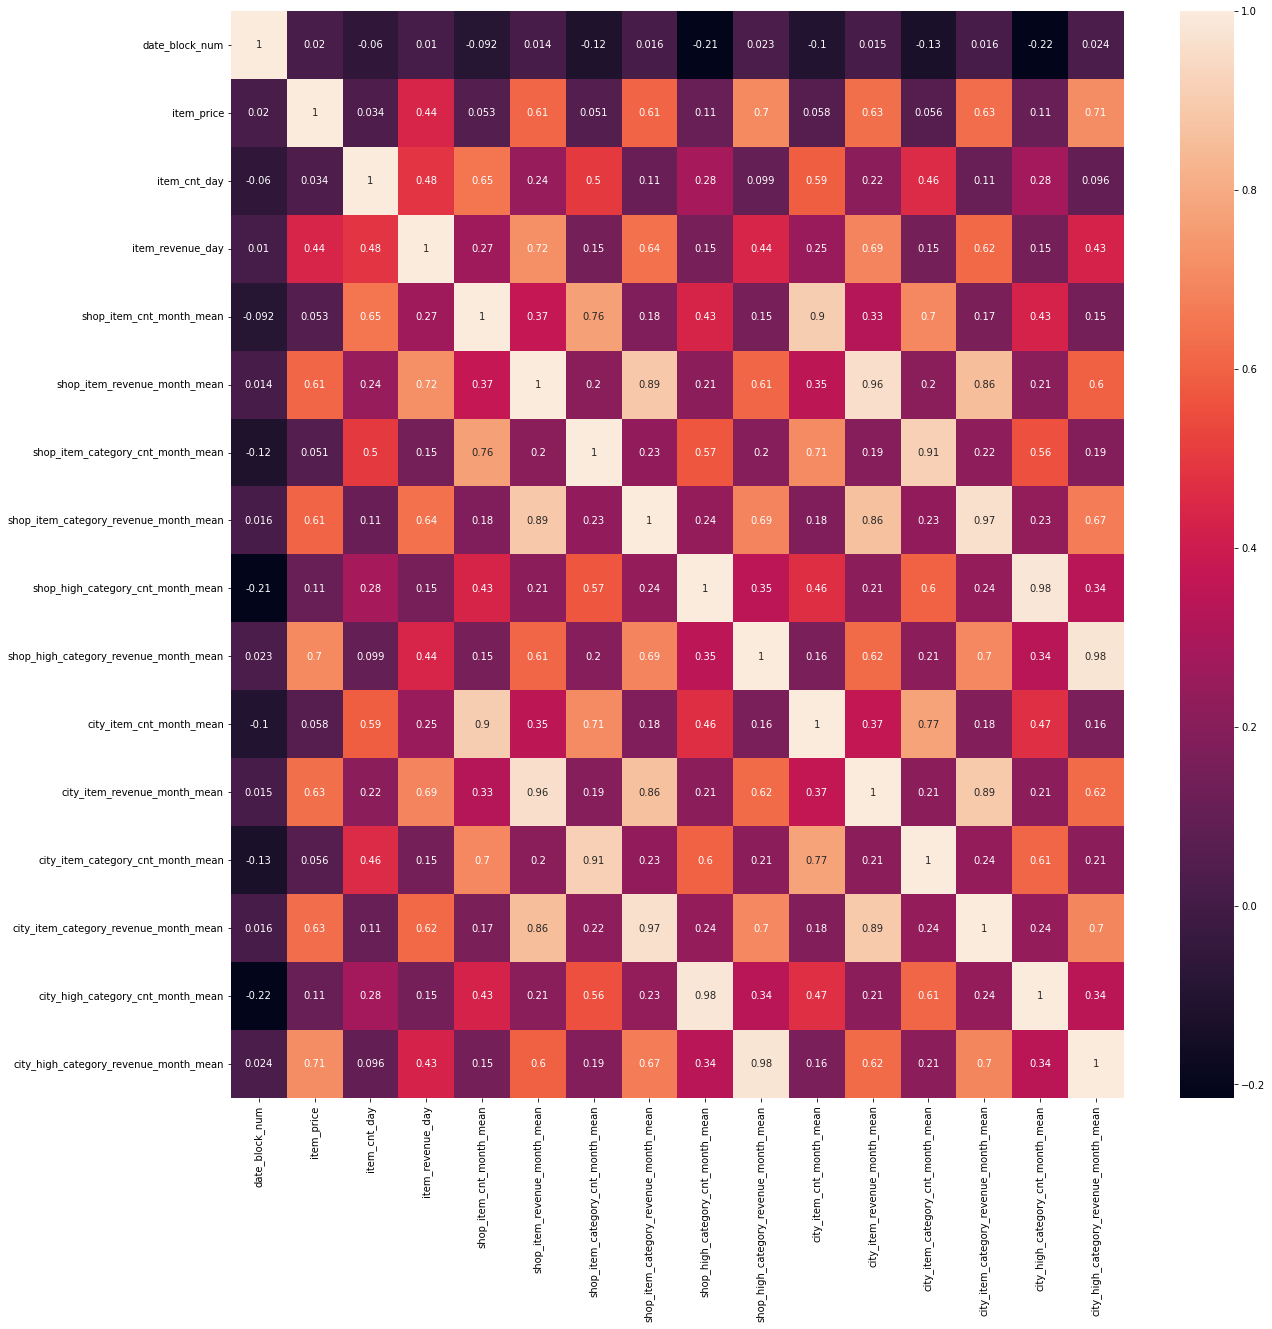

In [207]:
plt.figure(figsize=(20,20))
sns.heatmap(sales_df.corr() , annot=True)
plt.show()

In [208]:
train = train.pivot_table(index = ['date_block_num','shop_id','item_id','item_price'] , values=['item_cnt_day'],aggfunc='sum')
train.rename(columns = {'item_cnt_day':'item_cnt_month'}, inplace = True)
train.head()

item_cnt_month
date_block_num shop_id item_id item_price                
0              2       27      2499.0                 1.0
                       33      499.0                  1.0
                       317     299.0                  1.0
                       438     299.0                  1.0
                       471     399.0                  2.0

# Holdsout

In [209]:
x_train = sales_df[sales_df['date_block_num'] < 33]
x_train = x_train.drop(['item_cnt_day'], axis = 1)
y_train = sales_df[sales_df['date_block_num'] < 33]['item_cnt_day']


x_valid = sales_df[sales_df['date_block_num'] == 33]
x_valid = x_valid.drop(['item_cnt_day'], axis = 1)
y_valid = sales_df[sales_df['date_block_num'] == 33]['item_cnt_day']

x_test = sales_df[sales_df['date_block_num'] == 34]
x_test = x_test.drop(['item_cnt_day'], axis = 1)
y_test = sales_df[sales_df['date_block_num'] == 34]['item_cnt_day']

#### 랜덤포레스트_정확도

In [210]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [212]:
# max_attributes = x_valid.shape[1]
# depth_range = range(1, max_attributes)

for depth in range(1,4):
    rand_clf = RandomForestRegressor(n_estimators=200, max_depth = depth)
    model = rand_clf.fit(x_train, y_train)
    valid_acc = model.predict(x_valid)
    
    print("Current max depth: ", depth, "\n")
    print("Accuracy:", r2_score(y_valid, valid_acc))

Current max depth:  1 

Accuracy: 0.16456232138732996


KeyboardInterrupt: 

In [ ]:
rand_clf = RandomForestRegressor(n_estimators=200, max_depth = 22)
model = rand_clf.fit(x_train, y_train)

In [ ]:
valid_acc = model.predict(x_valid)


In [ ]:
valid_acc

In [ ]:
submission = pd.read_csv("./data/sample_submission.csv")
submission['item_cnt_month'] = valid_acc.clip(0,20)
submission.to_csv('submission.csv', index=False)

In [ ]:
r2_score(y_valid, valid_acc)